# cNMF in `cellarium-ml`

Stephen Fleming, Yang Xu

2025.07.31

The `cellarium-ml` project:

https://github.com/cellarium-ai/cellarium-ml

The specific implementation of cNMF we are actively working on:

https://github.com/cellarium-ai/cellarium-ml/pull/196

## Overview

`cellarium-ml` implements a variety of algorithms in a way that is scalable to hundreds of millions of cells and beyond.
This notebook provides a demo run of Cellarium's implementation of consensus NMF (cNMF).
The specific algorithm for NMF is based on "Online learning for matrix factorization and sparse coding" by Mairal, Bach, Ponce, and Sapiro (JMLR 2010).

## This notebook

This notebook shows an end-to-end cNMF run in `cellarium-ml`, starting with h5ad files and ending with results.
There are several steps involved.

## Description of analysis steps

1. Compute highly-variable genes.

2. Run cNMF on selected highly-variable genes.

3. Interactive plotting in this notebook to help determine optimal number of programs `k`, and a 
   `density_threshold` and `local_neighborhood_size` for the consensus step.

4. Computing consensus factors.

5. (Optional) Computing per-cell factor loadings.

6. (Optional) Re-computing the `k` factor definitions using all genes (not just highly-variable genes).

## Inputs

- a lits of filepaths to h5ad files: can be local or in a google bucket (or at some URL)
    - ideally the h5ad files would be from an extracted curriculum from `cellarium-nexus`, but these files can be any h5ad files
        - until [#324](https://github.com/cellarium-ai/cellarium-ml/issues/324) is resolved, the h5ad files
          should be limited in size to what can fit in memory

## Outputs (work in progress... not complete)

- anndata object for all cells (with an empty count matrix) containing:
    - `adata.obsm["X_cnmf_k20"]`: (cell, k) matrix of per-cell factor loadings (for the `k = 20` decomposition)
    - `adata.obsp["cnmf_k20_factors_hvg"]`: (gene, k) matrix of definitions of each of the `k` consensus programs
        - from the initial cNMF fit: all non-highly-variable genes have weight zero
    - `adata.obsp["cnmf_k20_factors_hvg_tpm"]`: (gene, k) matrix of definitions of each of the `k` consensus programs
        - same as above but weights are recomputed to represent TPM values via a refitting step
    - `adata.obsp["cnmf_k20_factors"]`: (gene, k) matrix of definitions of each of the `k` consensus programs
        - computed by refitting cell loadings from `adata.obsp["cnmf_k20_factors_hvg"]` by refitting the dataset including all genes
    - `adata.obsp["cnmf_k20_factors_tpm"]`: (gene, k) matrix of definitions of each of the `k` consensus programs
        - same as above but weights are recomputed to represent TPM values via a refitting step
    - (optionally): all of the above for other choices of `k` as well

NOTE: You will need to use the `nmf_sf_singlenotebook` branch of `cellarium-ml` on github

In [1]:
import cellarium.ml.preprocessing
import cellarium.ml.data
import cellarium.ml.transforms
import cellarium.ml.api
import cellarium.ml.models

import lightning.pytorch as pl
import numpy as np

/Users/sfleming/miniconda3/envs/cellarium/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

# Data

In [3]:
# the data

# CZI dataset is PBMCs from https://cellxgene.cziscience.com/e/59b69042-47c2-47fd-ad03-d21beb99818f.cxg/

h5ad_paths = [
    "https://datasets.cellxgene.cziscience.com/a06a1d9e-b1e8-452a-bf83-8ef6ec1044ec.h5ad"
    # "https://storage.googleapis.com/dsp-cellarium-cas-public/test-data/test_0.h5ad",
    # "https://storage.googleapis.com/dsp-cellarium-cas-public/test-data/test_1.h5ad",
    # "https://storage.googleapis.com/dsp-cellarium-cas-public/test-data/test_2.h5ad",
]

In [4]:
# for demonstration purposes: automatically grab h5ad file paths from a bucket prefix, like data from Nexus

try:
    example_cellarium_curriculum_h5ad_paths = cellarium.ml.api.h5ad_paths_from_google_bucket(
        "gs://cellarium-nexus-file-system-335649/pipeline/data-extracts/TEST2/extract_files"
    )
    print("Example of how to grab files from a Nexus curriculum bucket path:")
    print(f"[{example_cellarium_curriculum_h5ad_paths[0]}, ...]")
except:
    pass

Example of how to grab files from a Nexus curriculum bucket path:
[gs://cellarium-nexus-file-system-335649/pipeline/data-extracts/TEST2/extract_files/extract_0.h5ad, ...]


## Cellarium data setup

For this demo we are using the python API for cellarium.  It's also possible to use command line versions of these tools.

In [5]:
h5ad_paths

['https://datasets.cellxgene.cziscience.com/a06a1d9e-b1e8-452a-bf83-8ef6ec1044ec.h5ad']

(For remote files over the internet, this next cell can take a minute.)

In [6]:
datamodule = cellarium.ml.CellariumAnnDataDataModule(
    dadc=cellarium.ml.data.DistributedAnnDataCollection(
        filenames=h5ad_paths,
        limits=np.cumsum(cellarium.ml.api.get_h5ad_files_n_cells(h5ad_paths))
    ),
    batch_keys={
        "x_ng": cellarium.ml.utilities.data.AnnDataField(attr="X", convert_fn=cellarium.ml.utilities.data.densify),
        "var_names_g": cellarium.ml.utilities.data.AnnDataField(attr="var_names"),
        "obs_names_n": cellarium.ml.utilities.data.AnnDataField(attr="obs_names"),
    },
    batch_size=1024,
    shuffle=True,
    train_size=1.0,
)

datamodule.setup(stage="fit")

# Highly variable genes

## Run onepass model

This computes mean and variance per gene.

In [7]:
# get gene names to use later (and assume all files have the same genes)

var_names_g = cellarium.ml.api.get_h5ad_file_var_names_g(h5ad_paths[0])
var_names_g[:3]

array(['ENSG00000161920', 'ENSG00000272622', 'ENSG00000122335'],
      dtype='<U15')

In [8]:
# set up the model that will be used to compute mean and var of each gene

onepass_module = cellarium.ml.CellariumModule(
    transforms=[
        cellarium.ml.transforms.NormalizeTotal(),
        cellarium.ml.transforms.Log1p(),
    ],
    model=cellarium.ml.models.OnePassMeanVarStd(
        var_names_g=cellarium.ml.api.get_h5ad_file_var_names_g(h5ad_paths[0]),
    )
)

In [9]:
trainer = pl.Trainer(
    accelerator="cpu",
    devices=1,
    max_epochs=1,
    default_root_dir="tmp/onepass",
)
trainer.fit(onepass_module, datamodule)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name     | Type              | Params | Mode 
-------------------------------------------------------
0 | pipeline | CellariumPipeline | 1      | train
-------------------------------------------------------
1         Trainable params
0         Non-trainable params
1         Total params
0.000     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 48/48 [00:05<00:00,  8.45it/s, v_num=14]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 48/48 [00:05<00:00,  8.43it/s, v_num=14]


In [10]:
# the onepass model computes a mean and variance per gene

mean_g = trainer.model.model.mean_g
var_g = trainer.model.model.var_g

## Compute hvgs

You can choose `n_top_genes` to suit your needs.

In [11]:
var = cellarium.ml.preprocessing.get_highly_variable_genes(
    gene_names=var_names_g,
    mean=mean_g,
    var=var_g,
    n_top_genes=2000,
)
var

,means,dispersions,mean_bin,dispersions_norm,highly_variable
ENSG00000161920,0.244389,0.308106,"(0.24, 0.3]",0.109413,False
ENSG00000272622,0.000359,0.772813,"(-0.0012, 0.06]",2.275874,True
ENSG00000122335,0.047809,0.471847,"(-0.0012, 0.06]",-0.021823,False
ENSG00000175548,0.039010,0.430394,"(-0.0012, 0.06]",-0.338290,False
ENSG00000176340,0.832542,-0.631454,"(0.78, 0.84]",-1.340732,False
...,...,...,...,...,...
ENSG00000259224,0.000335,0.340102,"(-0.0012, 0.06]",-1.027617,False
ENSG00000248991,0.028386,0.385193,"(-0.0012, 0.06]",-0.683375,False
ENSG00000106780,0.293624,0.237828,"(0.24, 0.3]",-0.728343,False
ENSG00000223734,0.001630,0.474816,"(-0.0012, 0.06]",0.000845,False


In [12]:
var['highly_variable'].sum()

2000

In [13]:
# the highly variable genes

hvg_var_names_g = var.index[var['highly_variable']]
hvg_var_names_g

Index(['ENSG00000272622', 'ENSG00000181240', 'ENSG00000168229',
       'ENSG00000263677', 'ENSG00000148498', 'ENSG00000162894',
       'ENSG00000164692', 'ENSG00000163131', 'ENSG00000187837',
       'ENSG00000181896',
       ...
       'ENSG00000089472', 'ENSG00000164483', 'ENSG00000180532',
       'ENSG00000235531', 'ENSG00000120693', 'ENSG00000138835',
       'ENSG00000271717', 'ENSG00000204310', 'ENSG00000254614',
       'ENSG00000256576'],
      dtype='object', length=2000)

# cNMF

## Run NMF

Set things up to run cNMF in cellarium.

In [14]:
# user's choice for the number of components: must input a python list

# k_values = [10, 20, 30]
k_values = list(range(3, 30))

In [ ]:
nmf_model = cellarium.ml.models.NonNegativeMatrixFactorization(
    full_g=len(var_names_g),
    var_names_hvg=hvg_var_names_g,
    k_values=k_values,
    r=50,
)

nmf_module = cellarium.ml.CellariumModule(
    cpu_transforms=[cellarium.ml.transforms.Filter(filter_list=hvg_var_names_g)],
    model=nmf_model,
)

datamodule.setup(stage="fit")

trainer_nmf = pl.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=5,
    default_root_dir="tmp/nmf",
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [18]:
trainer_nmf.fit(nmf_module, datamodule)


  | Name     | Type              | Params | Mode 
-------------------------------------------------------
0 | pipeline | CellariumPipeline | 1      | train
-------------------------------------------------------
1         Trainable params
0         Non-trainable params
1         Total params
0.000     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 48/48 [02:02<00:00,  0.39it/s, v_num=29]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 48/48 [02:03<00:00,  0.39it/s, v_num=29]


In [19]:
# see the shape of what has been inferred: [replicates, k, genes]

for k in nmf_model.k_values:
    print(getattr(nmf_model, f"D_{k}_rkg").shape)

torch.Size([50, 3, 2000])
torch.Size([50, 4, 2000])
torch.Size([50, 5, 2000])
torch.Size([50, 6, 2000])
torch.Size([50, 7, 2000])
torch.Size([50, 8, 2000])
torch.Size([50, 9, 2000])
torch.Size([50, 10, 2000])
torch.Size([50, 11, 2000])
torch.Size([50, 12, 2000])
torch.Size([50, 13, 2000])
torch.Size([50, 14, 2000])
torch.Size([50, 15, 2000])
torch.Size([50, 16, 2000])
torch.Size([50, 17, 2000])
torch.Size([50, 18, 2000])
torch.Size([50, 19, 2000])
torch.Size([50, 20, 2000])
torch.Size([50, 21, 2000])
torch.Size([50, 22, 2000])
torch.Size([50, 23, 2000])
torch.Size([50, 24, 2000])
torch.Size([50, 25, 2000])
torch.Size([50, 26, 2000])
torch.Size([50, 27, 2000])
torch.Size([50, 28, 2000])
torch.Size([50, 29, 2000])


## Set up to explore outputs

We have a helper class that facilitates downstream analysis steps. Here we instantiate it.

In [74]:
from cellarium.ml.models.nmf import NMFOutput

nmf_output = NMFOutput(
    nmf_module=nmf_module,
    datamodule=datamodule,
)

In [75]:
nmf_output

NMFOutput(
    nmf_module=CellariumModule(pipeline = CellariumPipeline(
          (0): Filter(filter_list=['ENSG00000272622' 'ENSG00000181240' 'ENSG00000168229' ...
           'ENSG00000204310' 'ENSG00000254614' 'ENSG00000256576'])
          (1): NonNegativeMatrixFactorization(
            (transform__filter_to_hvgs): Filter(filter_list=['ENSG00000272622' 'ENSG00000181240' 'ENSG00000168229' ...
             'ENSG00000204310' 'ENSG00000254614' 'ENSG00000256576'])
          )
        )),
    datamodule={Train dataloader: size=48}
        {Validation dataloader: size=0}
        {Test dataloader: None}
        {Predict dataloader: size=48}
)
with consensus []

## Default k-selection plot

This is what Kotliar cNMF would produce with default values for `local_neighborhood_size=0.3` and `density_threshold=0.5`

cellarium.ml.models.nmf:cNMF - INFO - Computing consensus factors with default hyperparameters...


INFO:cellarium.ml.models.nmf:Computing consensus factors with default hyperparameters...


cellarium.ml.models.nmf:cNMF - INFO - Calculating reconstruction error (requires an entire pass through the data)...


INFO:cellarium.ml.models.nmf:Calculating reconstruction error (requires an entire pass through the data)...
100%|██████████| 48/48 [00:22<00:00,  2.12it/s]


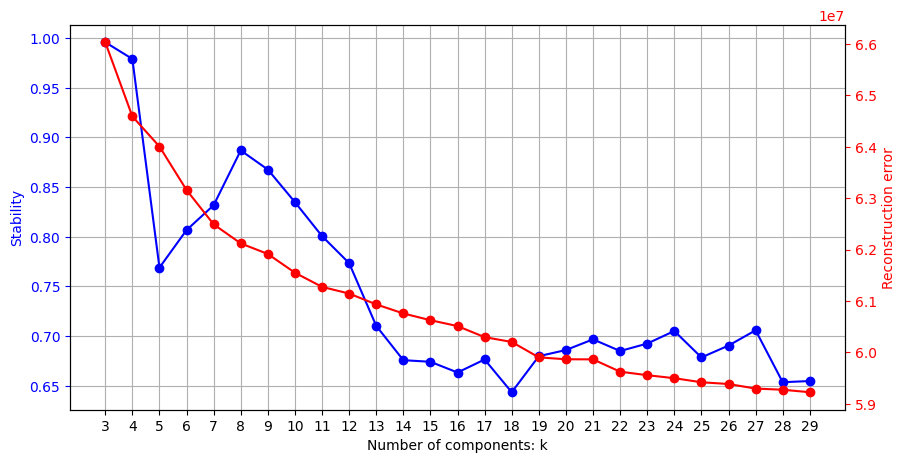

In [76]:
nmf_output.default_k_selection_plot()

## Compute consensus factors

This step requires hyperparamter choices.

The way the Kotliar cNMF demo notebook works, you first select a `k` of interest and make these choices for that particular `k`.

Let's start by picking a k-value and looking at what Kotliar calls the "local density histogram".

In [77]:
best_k = 8

### Density histograms

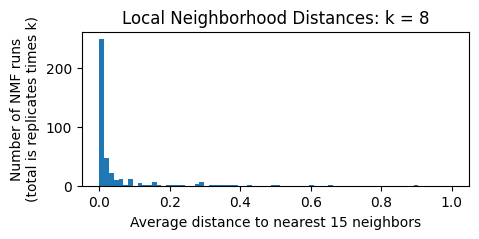

In [78]:
nmf_output.plot_density_histograms(k_values=[8], local_neighborhood_size=0.3)

In [ ]:
# re-compute consensus D for all k-values, given hyperparamter choices

density_threshold = 0.1  # change this threshold if desired based on the histogram above: idea is to remove outliers
local_neighborhood_size = 0.3  # this is a default that Kotliar leaves fixed in tutorials

nmf_output.compute_consensus_factors(
    k_values=[8],
    density_threshold=density_threshold,
    local_neighborhood_size=local_neighborhood_size,
)

In [80]:
# one key for each k-value

nmf_output.consensus.keys()

dict_keys([3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [81]:
# each k-value has a few things computed: these get updated if you re-compute consensus for a particular k value

nmf_output.consensus[best_k].keys()

dict_keys(['filtered_euclidean_distance_matrix', 'filtered_neighbor_distances', 'all_neighbor_distances', 'n_neighbors', 'consensus_D_kg', 'stability', 'local_neighborhood_size', 'density_threshold'])

In [82]:
# the shape of the consensus matrix for a particular k

nmf_output.consensus[best_k]['consensus_D_kg'].shape

torch.Size([8, 2000])

### Create clustermap plots

Here we again experiment with different `density_threshold` values. Plotting the clustermap with different `density_threshold` values actually re-computes consensus for that particular `k`.

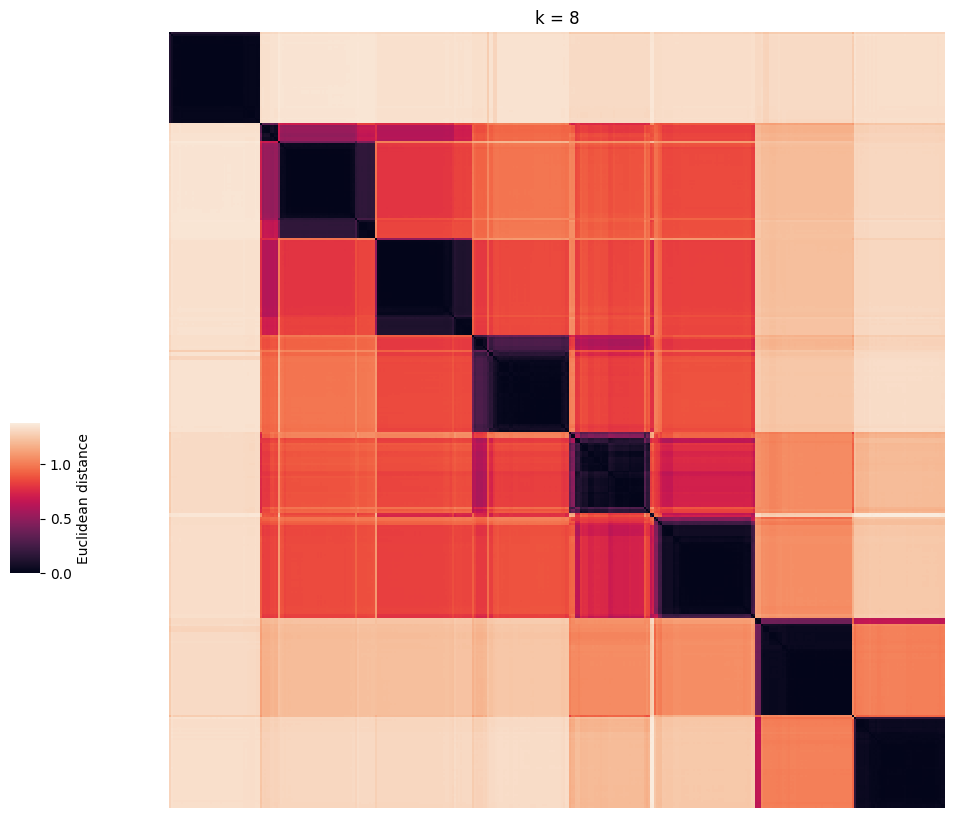

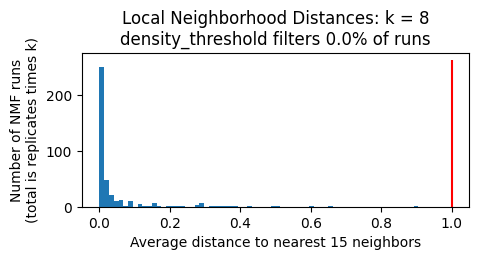

In [90]:
nmf_output.plot_clustermap(k=best_k, density_threshold=1.0)

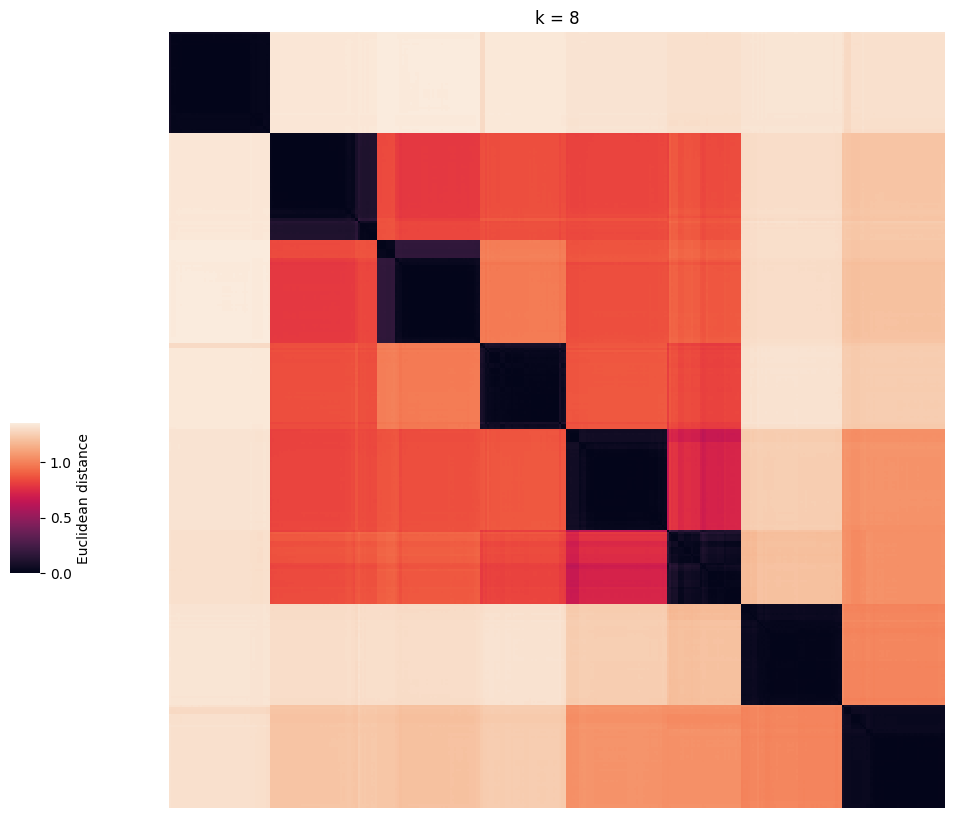

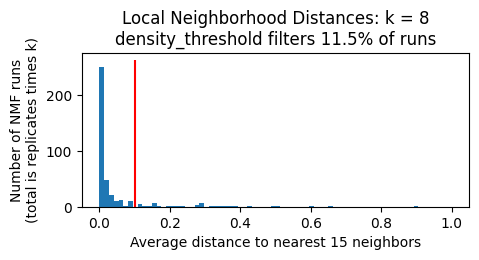

In [94]:
nmf_output.plot_clustermap(k=best_k, density_threshold=0.1)

## Compute reconstruction error at each k

Demonstration here in case you ever want to run this separately, but it gets run automatically as part of `nmf_output.default_k_selection_plot()`.

Technically the reconstruction error does depend on hyperparamter choices, because it depends on the consensus programs.

In [96]:
# we need to calculate the reconstruction error by going through the whole dataset: this can take time

nmf_output.calculate_reconstruction_error()

100%|██████████| 48/48 [00:18<00:00,  2.53it/s]


{3: 65947484.25,
 4: 64505485.25,
 5: 63925837.0,
 6: 63079932.375,
 7: 62409954.75,
 8: 62039261.625,
 9: 61833614.875,
 10: 61468209.5,
 11: 61193230.0,
 12: 61062034.375,
 13: 60851231.5,
 14: 60674751.375,
 15: 60543546.25,
 16: 60427279.5,
 17: 60212478.25,
 18: 60118974.875,
 19: 59819586.75,
 20: 59781812.875,
 21: 59779334.125,
 22: 59540342.625,
 23: 59472296.25,
 24: 59413925.625,
 25: 59335718.125,
 26: 59301957.0,
 27: 59211917.375,
 28: 59188412.25,
 29: 59140984.375}

## Other versions of the k-selection plot

Kotliar does not demo this, but the k-selection plot itself depends on the values of `density_threshold` and `local_neighborhood_size`.

In principle, you could choose different hyperparameters for each `k`, run `nmf_output.compute_consensus_factors(k, <your selected params here>)` on all the `k`, and then re-run `nmf_output.calculate_reconstruction_error()` and re-create the k-selection plot.

In [97]:
nmf_output.consensus[10]["density_threshold"]

0.5

In [98]:
nmf_output.consensus[8]["density_threshold"]

0.1

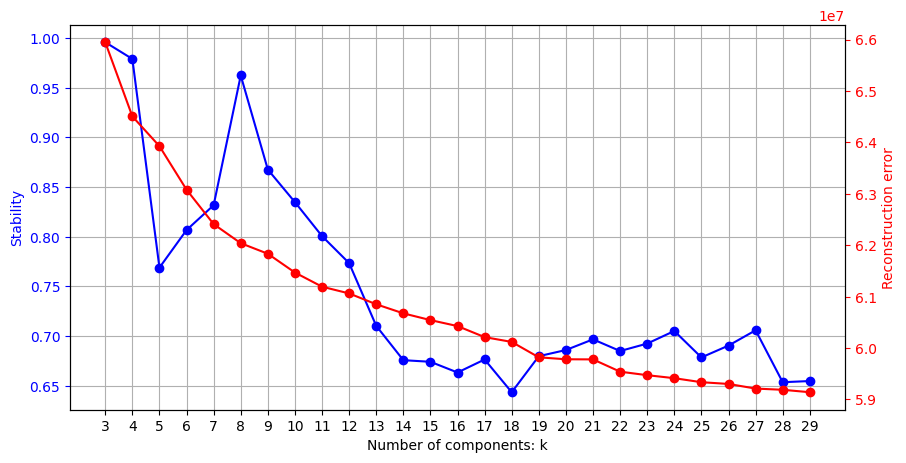

In [99]:
nmf_output.k_selection_plot()

See how the stability skyrocketed for `k=8` after we filtered at a different threshold?  :)

Different thresholds for different `k` hardly seems fair... unless you were to optimize the threshold for each `k` individually...

### Going down that rabbit hole

I don't recommend doing this, I was just interested.

Let's just see... I re-ran the following cell until I was happy with each `k`:

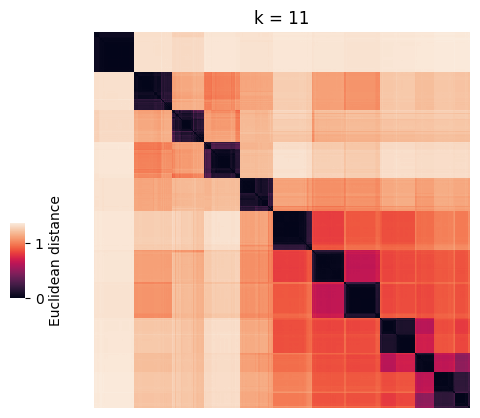

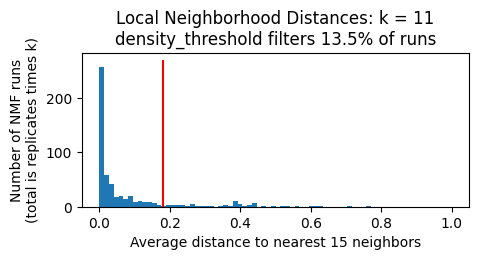

In [158]:
nmf_output.plot_clustermap(k=11, density_threshold=0.18)

In [154]:
# custom density threshold at each k

[(k, nmf_output.consensus[k]["density_threshold"]) for k in nmf_output.consensus.keys()]

[(3, 0.05),
 (4, 0.05),
 (5, 0.05),
 (6, 0.03),
 (7, 0.05),
 (8, 0.1),
 (9, 0.1),
 (10, 0.1),
 (11, 0.18),
 (12, 0.17),
 (13, 0.12),
 (14, 0.2),
 (15, 0.2),
 (16, 0.3),
 (17, 0.3),
 (18, 0.3),
 (19, 0.3),
 (20, 0.3),
 (21, 0.3),
 (22, 0.3),
 (23, 0.3),
 (24, 0.3),
 (25, 0.3),
 (26, 0.25),
 (27, 0.3),
 (28, 0.3),
 (29, 0.3)]

In [156]:
nmf_output.calculate_reconstruction_error()

100%|██████████| 48/48 [00:20<00:00,  2.33it/s]


{3: 65982831.5,
 4: 64540969.25,
 5: 63749412.875,
 6: 63110359.25,
 7: 62442339.5,
 8: 62072343.125,
 9: 61858906.25,
 10: 61499144.125,
 11: 61222825.0,
 12: 61131434.0,
 13: 60837308.375,
 14: 60759260.25,
 15: 60580223.625,
 16: 60468913.875,
 17: 60260070.5,
 18: 60122788.5,
 19: 59856857.25,
 20: 59818606.625,
 21: 59613134.125,
 22: 59615662.25,
 23: 59582842.75,
 24: 59508448.25,
 25: 59487188.75,
 26: 59449249.0,
 27: 59304768.875,
 28: 59316835.125,
 29: 59361938.25}

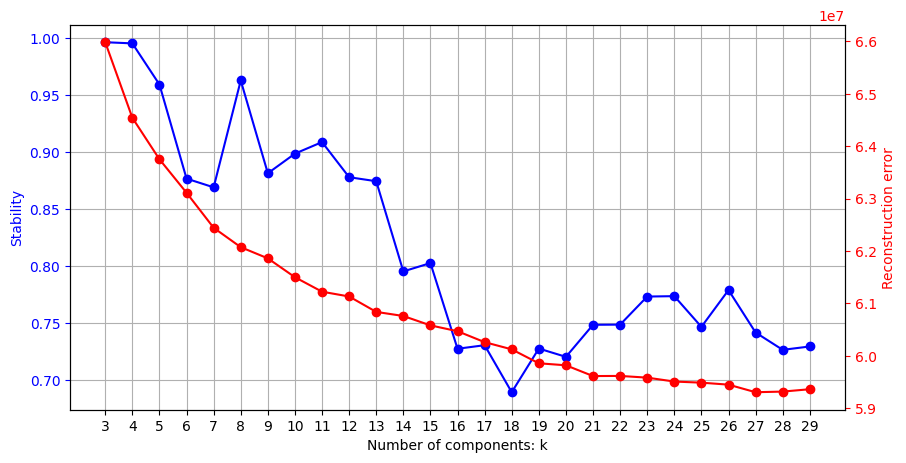

In [157]:
nmf_output.k_selection_plot()

Yeah so it's more or less similar to the original which used the same default hyperparamters for all `k`. Best `k` still looks like 8.

I mean I guess this shows there's a little peak in stability at `k=11` if you use the right params. There might be some reason to look at this occasionally.

## Compute per-cell loadings

The loadings of each factor, computed for each cell.

In [31]:
# get per-cell factor loadings using the best k: this takes time
# `normalize` controls whether the per-cell loadings sum to 1

df = nmf_output.compute_loadings(k=best_k, normalize=True)

100%|██████████| 6/6 [00:01<00:00,  4.06it/s]


In [32]:
df.shape

(300, 20)

In theory could add this information to the anndata object if you had a single object.
Here we will assume the dataset might be very large in total, so we will just try to open one h5ad file and add the annotations for those cells.

In [33]:
adata = cellarium.ml.data.read_h5ad_file(h5ad_paths[0])
adata

AnnData object with n_obs × n_vars = 100 × 36601
    obs: 'cell_type', 'cas_ingest_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'organism_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'tissue_ontology_term_id', 'assay', 'development_stage', 'disease', 'organism', 'self_reported_ethnicity', 'sex', 'tissue', 'total_mrna_umis', 'dataset_id', 'batch'
    layers: 'measured_genes_mask'

In [34]:
# add cNMF loadings to obsm

adata.obsm["X_nmf"] = df.loc[adata.obs_names].values
adata.obsm["X_nmf"].shape

(100, 20)

## Project factors back to all genes

Now refit for all genes, not just the highly variable genes. In cNMF this involves solving an auxiliary linear regression problem.

In [ ]:
full_D_kg = getattr(pipeline[-1], f"full_D_{best_k}_kg")
full_D_kg = full_D_kg.cpu().numpy()

full_D_kg = pd.DataFrame(full_D_kg)
full_D_kg.columns = adata.var.index
full_D_kg = full_D_kg.T

## Results as a summary anndata

The results can be packaged up into an anndata object if desired, and perhaps saved that way as an h5ad file.

Here we omit the actual count matrix, since in theory it is too big to fit in memory.